ddpg算法参考：https://cloud.tencent.com/developer/article/2483544

In [1]:
import torch
import torch.nn as nn
import numpy as np
import gym
import tushare as ts
import matplotlib.pyplot as plt

In [2]:
from IPython import display
display.set_matplotlib_formats("svg") ## 设置一下，这样一来，图片就是svg格式的矢量图了。

/var/folders/s1/1jpfx0m52rj4k7cgqkh7g3q40000gn/T/ipykernel_24235/2047429104.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg") ## 设置一下，这样一来，图片就是svg格式的矢量图了。


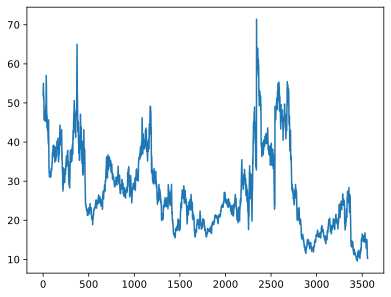

In [4]:
# 设置TuShare的token，需要提前在TuShare官网注册并获取token
token = "53b6254438e6d307b6799dbd575883528bc1da912f3d6a31159ecc9e"
ts.set_token(token)

# 初始化TuShare接口
pro = ts.pro_api()

# 数据收集
def collect_data():
    # 使用Tushare Pro版获取股票数据
    df = pro.daily(ts_code="000977.SZ", start_date="2010-01-01", end_date="2025-01-01")
    prices = df["close"].values.astype(float)
    return prices

prices = collect_data()

plt.plot(prices)

In [31]:
prices[0]

np.float64(51.88)

In [39]:
# 定义交易环境
class TradingEnvironment(gym.Env):
    '''总体给我的感觉，就是，一个管理强化学习状态的数据结构。
    比如当前的股价是多少，当前还有多少余钱，目前持股是多少。
    然后假设来了一个动作：买入、卖出、持有三者之一。
    之后，会有多少收益，然后能够达到的一个新的状态是怎么样的。
    最精华的部分应该是采取什么样的动作。这个东西需要后续的决策模块来做。
    '''
    def __init__(self, prices):
        super(TradingEnvironment, self).__init__()
        self.prices = prices ## 这个其实就是股价，一维向量，没啥特别的。
        self.current_step = 0 ## 当前步数。如果步数到达某一上限，学习过程就终止了。
        self.balance = 10000  # 初始资金
        self.stock_inventory = 0 ## 这个应该是持股的数量。
        self.max_steps = len(prices) ## 这个就是步数的上限，看来就是股价的个数。相当于就是把所有的股价都刷一遍，看最终能收益多少。
        self.action_space = gym.spaces.Discrete(3)  # 三个动作：买入、卖出、持有
        self.observation_space = gym.spaces.Box( ## 这个未知，不知道是啥东西。后续我们跑跑代码再看。
            low=0, high=np.inf, shape=(2,), dtype=np.float32
        )

    def reset(self):
        self.current_step = 0
        self.balance = 10000
        self.stock_inventory = 0
        return np.array([self.balance, self.stock_inventory]) ## 这个应该是状态，就是某时刻，有多少现金，有多少持股。

    def step(self, action):
        action_prob = torch.softmax(action, dim=-1)
        action_taken = np.random.choice(len(action), p=action_prob.detach().numpy())
        
        current_price = self.prices[self.current_step]
        if action_taken == 0:  # 买入
            if self.balance >= current_price:
                num_to_buy = int(self.balance / current_price)
                self.balance -= num_to_buy * current_price
                self.stock_inventory += num_to_buy
        elif action_taken == 1:  # 卖出
            if self.stock_inventory > 0:
                self.balance += self.stock_inventory * current_price
                self.stock_inventory = 0
        self.current_step += 1 ## 
        done = self.current_step >= self.max_steps
        reward = self.balance + self.stock_inventory * current_price - 10000  # 计算奖励 ## 看上去就是，把当前的余额和股票换算成钱，看跟最开始比挣了多少钱。 
        ## 每一步，返回一个，当前的余额、持股、收益、是否完结。最后一个空的dict不知道是什么意思。
        state = np.array([self.balance, self.stock_inventory])
        return state, reward, done, {}

In [52]:
import torch.optim as optim  # 导入 PyTorch 的优化器模块
from collections import deque
import random  # 导入随机模块，用于从经验池中采样

In [53]:
# 定义 Actor 网络（策略网络）
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)  # 输入层到隐藏层1，大小为 256
        self.layer2 = nn.Linear(256, 256)  # 隐藏层1到隐藏层2，大小为 256
        self.layer3 = nn.Linear(256, action_dim)  # 隐藏层2到输出层，输出动作维度
        self.max_action = max_action  # 动作的最大值，用于限制输出范围

    def forward(self, state):
        x = torch.relu(self.layer1(state))  # 使用 ReLU 激活函数处理隐藏层1
        x = torch.relu(self.layer2(x))  # 使用 ReLU 激活函数处理隐藏层2
        x = torch.tanh(self.layer3(x)) * self.max_action  # 使用 Tanh 激活函数，并放大到动作范围
        return x  # 返回输出动作

# 定义 Critic 网络（价值网络）
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, 256)  # 将状态和动作拼接后输入到隐藏层1
        self.layer2 = nn.Linear(256, 256)  # 隐藏层1到隐藏层2，大小为 256
        self.layer3 = nn.Linear(256, 1)  # 隐藏层2到输出层，输出 Q 值

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)  # 将状态和动作拼接为单个输入
        x = torch.relu(self.layer1(x))  # 使用 ReLU 激活函数处理隐藏层1
        x = torch.relu(self.layer2(x))  # 使用 ReLU 激活函数处理隐藏层2
        x = self.layer3(x)  # 输出 Q 值
        return x  # 返回 Q 值

# 定义经验回放池
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)  # 初始化一个双端队列，设置最大容量

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))  # 将经验存入队列

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)  # 随机采样一个小批量数据
        states, actions, rewards, next_states, dones = zip(*batch)  # 解压采样数据
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))  # 返回 NumPy 数组格式的数据

    def size(self):
        return len(self.buffer)  # 返回经验池中当前存储的样本数量

# DDPG智能体类定义
class DDPGAgent:
    # 初始化方法，设置智能体的参数和模型
    def __init__(self, state_dim, action_dim, max_action, gamma=0.99, tau=0.005, buffer_size=100000, batch_size=64):
        # 定义actor网络（策略网络）及其目标网络
        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = Actor(state_dim, action_dim, max_action)
        # 将目标actor网络的参数初始化为与actor网络一致
        self.actor_target.load_state_dict(self.actor.state_dict())
        # 定义actor网络的优化器
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        # 定义critic网络（值网络）及其目标网络
        self.critic = Critic(state_dim, action_dim)
        self.critic_target = Critic(state_dim, action_dim)
        # 将目标critic网络的参数初始化为与critic网络一致
        self.critic_target.load_state_dict(self.critic.state_dict())
        # 定义critic网络的优化器
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        # 保存动作的最大值，用于限制动作范围
        self.max_action = max_action
        # 折扣因子，用于奖励的时间折扣
        self.gamma = gamma
        # 软更新系数，用于目标网络的更新
        self.tau = tau
        # 初始化经验回放池
        self.replay_buffer = ReplayBuffer(buffer_size)
        # 每次训练的批量大小
        self.batch_size = batch_size

    # 选择动作的方法
    def select_action(self, state):
        # 将状态转换为张量
        state = torch.FloatTensor(state.reshape(1, -1))
        # 使用actor网络预测动作，并将结果转换为NumPy数组
        action = self.actor(state).detach().cpu().flatten() #.numpy()
        return action

    # 训练方法
    def train(self):
        # 如果回放池中样本数量不足，直接返回
        if self.replay_buffer.size() < self.batch_size:
            return

        # 从回放池中采样一批数据
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # 将采样的数据转换为张量
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)  # 添加一个维度以匹配Q值维度
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)  # 添加一个维度以匹配Q值维度

        # 计算critic的损失
        with torch.no_grad():  # 关闭梯度计算
            next_actions = self.actor_target(next_states)  # 使用目标actor网络预测下一步动作
            target_q = self.critic_target(next_states, next_actions)  # 目标Q值
            # 使用贝尔曼方程更新目标Q值
            target_q = rewards + (1 - dones) * self.gamma * target_q

        # 当前Q值
        current_q = self.critic(states, actions)
        # 均方误差损失
        critic_loss = nn.MSELoss()(current_q, target_q)

        # 优化critic网络
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 计算actor的损失
        actor_loss = -self.critic(states, self.actor(states)).mean()  # 策略梯度目标为最大化Q值

        # 优化actor网络
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新目标网络参数（软更新）
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    # 将样本添加到回放池中
    def add_to_replay_buffer(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)

In [54]:
# 训练策略网络
def train_policy_network(prices, l2_reg=0.01):  # 添加L2正则化的参数
    
    env = TradingEnvironment(prices)
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    max_action = 1 # flaot(env.action_space.high)
    
    # 初始化DDPG智能体
    agent = DDPGAgent(state_dim, action_dim, max_action)
    rewards = []  # 用于存储每个episode的奖励
    num_episodes = 100 ## 次数缩减一下吧，不要跑辣么多。

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        while True: ## 其实这里就是把训练数据里面的所有的股价都过一遍。就这么简单。
            ## select an action: 
            action = agent.select_action(state)
            ## practice the action: 
            next_state, reward, done, _ = env.step(action)
            ## put the example into the replay pool:
            agent.add_to_replay_buffer(state, action, reward, next_state, done)
            ## train the intelligent agent:
            agent.train()

            ## collect some rewards and states. 
            episode_reward += reward
            state = next_state

            ## if run out of the prices, then break. 
            if done:
                break

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}/{num_episodes}, Reward: {episode_reward:.2f}")
            rewards.append(episode_reward)

    return agent, rewards

In [58]:
import pickle, joblib
def save_pickle_object(obj, path):
    model_path = path
    with open(model_path, "wb") as f:
        pickle.dump(obj, f, protocol=2)
    print(model_path)
def load_pickle_object(path):
    return joblib.load(path)

In [55]:
# 主函数
if __name__ == "__main__":
    # 收集数据
    # prices = collect_data()

    # 训练策略网络，传递L2正则化参数
    policy_network, rewards = train_policy_network(prices + 1e-3, l2_reg=0.01)

    # 保存模型
    save_pickle_object(policy_network, "policy_network.pkl")

    # 绘制奖励曲线
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Reward Curve")
    plt.show()

Episode 10/100, Reward: -7149914.76
Episode 20/100, Reward: -12135177.90
Episode 30/100, Reward: 4833558.55
Episode 40/100, Reward: -2537113.18
Episode 50/100, Reward: 6686870.92
Episode 60/100, Reward: -6382286.55
Episode 70/100, Reward: -5945281.32
Episode 80/100, Reward: -12415466.88
Episode 90/100, Reward: -4220439.08
Episode 100/100, Reward: -10282477.30


AttributeError: 'DDPGAgent' object has no attribute 'state_dict'

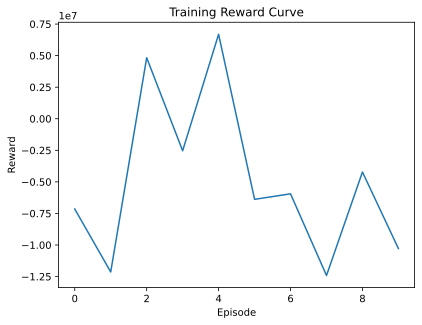

In [57]:
# plt.plot(rewards)
# plt.xlabel("Episode")
# plt.ylabel("Reward")
# plt.title("Training Reward Curve")
# plt.show()